# Let's look at dataset
At first, let's download and unpack train dataset and trainsform it into readable view

In [1]:
# Take full path of mat file
import os
dataset_folder = 'SVHN_data'
train_folder = 'train'
mat_filename = !ls SVHM_data/train/ | grep 'mat'
mat_filepath = os.path.join(dataset_folder, train_folder, mat_filename[0])
print("Mat file for train dataset is", mat_filepath)

Mat file for train dataset is SVHM_data/train/digitStruct.mat


In [3]:
# scipy.io.loadmat don't work with mat 7.3
import h5py

file = h5py.File(mat_filepath, 'r')

In [4]:
for i in list(file.items()):
    print(i)

('#refs#', <HDF5 group "/#refs#" (100005 members)>)
('digitStruct', <HDF5 group "/digitStruct" (2 members)>)


In [5]:
digitStruct = file['digitStruct']
for i in list(digitStruct.items()):
    print(i)

('bbox', <HDF5 dataset "bbox": shape (33402, 1), type "|O">)
('name', <HDF5 dataset "name": shape (33402, 1), type "|O">)


In [6]:
digitStruct['name'][0:3]

array([[<HDF5 object reference>],
       [<HDF5 object reference>],
       [<HDF5 object reference>]], dtype=object)

In [9]:
name_ref = digitStruct['name'][0][0]
print(name_ref)
name = file[name_ref]
print(name)

<HDF5 object reference>
<HDF5 dataset "b": shape (5, 1), type "<u2">


In [10]:
image_name = "".join(chr(i) for i in name)
print(image_name)

1.png


In [11]:
boxes = digitStruct['bbox']
print(boxes)

<HDF5 dataset "bbox": shape (33402, 1), type "|O">


In [12]:
box_ref = boxes[0][0]
print(box_ref)
box = file[box_ref]
print(box)

<HDF5 object reference>
<HDF5 group "/#refs#/VQi" (5 members)>


In [13]:
list(box.items())

[('height', <HDF5 dataset "height": shape (2, 1), type "|O">),
 ('label', <HDF5 dataset "label": shape (2, 1), type "|O">),
 ('left', <HDF5 dataset "left": shape (2, 1), type "|O">),
 ('top', <HDF5 dataset "top": shape (2, 1), type "|O">),
 ('width', <HDF5 dataset "width": shape (2, 1), type "|O">)]

Seems like image 1.png has 2 digits. So let's check it!

In [18]:
import scipy.ndimage as ndimg
import matplotlib.pyplot as plt

In [17]:
first_image = ndimg.imread(os.path.join(dataset_folder, 'train', image_name))

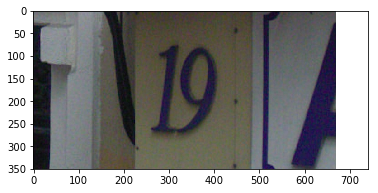

In [20]:
plt.imshow(first_image)
plt.show()

That's right. But what about other images with more digits

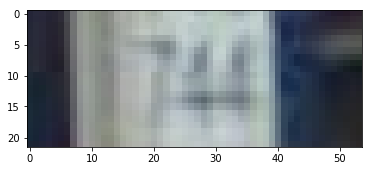

In [29]:
img = ndimg.imread(os.path.join(dataset_folder, 'train', '8.png'))
plt.imshow(img)
plt.show()

In [32]:
box_ref = boxes[8-1][0]
print(box_ref)
box = file[box_ref]
print(box)

<HDF5 object reference>
<HDF5 group "/#refs#/aSi" (5 members)>


In [34]:
box_properties = list(box.items())
for prop in box_properties:
    print(prop)

('height', <HDF5 dataset "height": shape (3, 1), type "|O">)
('label', <HDF5 dataset "label": shape (3, 1), type "|O">)
('left', <HDF5 dataset "left": shape (3, 1), type "|O">)
('top', <HDF5 dataset "top": shape (3, 1), type "|O">)
('width', <HDF5 dataset "width": shape (3, 1), type "|O">)


That's correct! There are as many propertices as many digits on image. But what are some properties here? top, left?

In [90]:
box['height']

<HDF5 dataset "height": shape (3, 1), type "|O">

In [91]:
boxes_info = [{} for i in range(len(box['height']))]

In [129]:
for key, ds in box.items():
    for i, ref in enumerate(ds):
        prop_val = next(int(j) for j in file[ref[0]])
        boxes_info[i][key] = prop_val

In [130]:
boxes_info

[{'height': 15, 'label': 7, 'left': 17, 'top': 4, 'width': 7},
 {'height': 15, 'label': 4, 'left': 25, 'top': 4, 'width': 6},
 {'height': 15, 'label': 4, 'left': 31, 'top': 3, 'width': 7}]

Seems like it works slowly when you dereference something.  
But it's a constant delay. After that other operations in flow go fast.  
Seems like it opens / closes each time or something.

Let's draw boxes on image to fully understand what is what

In [153]:
import PIL

In [154]:
pil_img = PIL.Image.fromarray(img)

In [155]:
pil_img

Oh, tiny image. It's so cute!

Let's draw borders on it

In [156]:
draw = PIL.ImageDraw.Draw(pil_img)

In [157]:
for box_info in boxes_info:
    x = box_info['left']
    y = box_info['top']
    width = box_info['width']
    height = box_info['height']
    draw.rectangle([x, y, x+width, y+height])

In [158]:
scale = 6
bigger_size = [size*scale for size in pil_img.size]

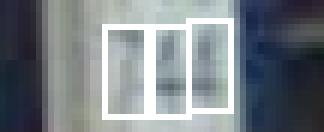

In [159]:
pil_img.resize(bigger_size)

Whoa! It works!

We can start extracting data from it already

I saw cool idea to collect referencies and then fill data with values

Some ideas to speed up the process:
1. Change driver to buffered (stdio) http://docs.h5py.org/en/latest/high/file.html#file-driver 
2. Use with operator

Tried first one, but no result  
But second case seems a little bit faster

In [ ]:
class Image:
    pass

In [ ]:
class Box:
    pass

In [205]:
def info_from_mat(mat_filename):
    with h5py.File(mat_filename, 'r') as f:
        def name_by_ref(f, ref):
            name_ds = f[ref]
            name = "".join(chr(i) for i in name_ds)
            return name
        
        def boxes_by_ref(f, ref):
            img_boxes = f[ref]
            num_boxes = len(img_boxes['height'])
            boxes_info = [{} for i in range(num_boxes)] # Not efficend for memory, but easier to implement
            for key, ds in img_boxes.items():
                for i, prop_ref in enumerate(ds):
                    if num_boxes == 1:
                        prop_val = prop_ref[0]
                    else:
                        prop_val = next(int(j) for j in f[prop_ref[0]])
                        
                    boxes_info[i][key] = prop_val
            return boxes_info
        
        
        ds = f['digitStruct']
        ds_boxes = ds['bbox']
        ds_names = ds['name']
        
        n = len(ds_boxes)
        names = [None for i in range(n)]
        boxes = [None for i in range(n)]
        for i in range(n):
            name_ref = ds_names[i][0]
            boxes_ref = ds_boxes[i][0]
            
            names[i] = name_by_ref(f, name_ref)
            boxes[i] = boxes_by_ref(f, boxes_ref)
        
        return names, boxes

Special case was needed for 1-digit images

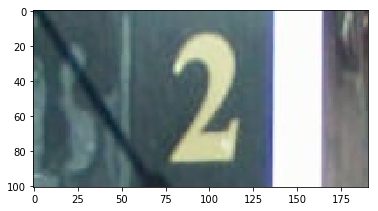

In [190]:
i = ndimg.imread(os.path.join(dataset_folder, 'train', '21.png'))
plt.imshow(i)
plt.show()

In [192]:
b = file[boxes[20][0]]

In [195]:
list(b.items())

[('height', <HDF5 dataset "height": shape (1, 1), type "<f8">),
 ('label', <HDF5 dataset "label": shape (1, 1), type "<f8">),
 ('left', <HDF5 dataset "left": shape (1, 1), type "<f8">),
 ('top', <HDF5 dataset "top": shape (1, 1), type "<f8">),
 ('width', <HDF5 dataset "width": shape (1, 1), type "<f8">)]

In [197]:
int(next(i for i in b['height']))

85

In [198]:
for i, prop_ref in enumerate(b['height']):
    print(i, prop_ref)

0 [ 85.]


## Let's extract our data!
It was very fast! 1 - 3 minutes

In [211]:
names, boxes = info_from_mat(mat_filepath)

In [245]:
train_dataset = dict(zip(names, boxes))

In [239]:
import pickle

In [263]:
f = open('train.pickle', 'wb')
pickle.dump(train_dataset, f, protocol=pickle)
f.close()

# Download and extract all needed data

### Download and extract datasets archives

In [3]:
import os
dataset_folder = 'SVHN_data'

In [4]:
import requests

urls = {
    'train.tar.gz': 'http://ufldl.stanford.edu/housenumbers/train.tar.gz',
    'test.tar.gz' : 'http://ufldl.stanford.edu/housenumbers/test.tar.gz'
}

# Download archives
for dataset_filename, url in urls.items():
    full_filepath = os.path.join(dataset_folder, dataset_filename)
    if not os.path.exists(full_filepath):
        print("{} doesn't exists. Start downloading...".format(full_filepath))
        response = requests.get(url)
        with open(full_filepath, 'wb') as f:
            f.write(response.content)
print('All datasets archives were downloaded')

All datasets archives were downloaded


In [5]:
import tarfile
import re

# Extract archives
for dataset_archive_name in urls.keys():
    full_archive_name = os.path.join(dataset_folder, dataset_archive_name)
    full_folder_name = re.sub('.tar.gz', '', full_archive_name)
    if not os.path.exists(full_folder_name):
        print("{} was not extracted".format(dataset_archive_name))
        print("Working on it")
        with tarfile.open(full_archive_name) as dataset_file:
            dataset_file.extractall(dataset_folder)
print('All archives were extracted in {} directory'.format(dataset_folder))

All archives were extracted in SVHN_data directory


### Extract labels information from mat files using h5py library

In [6]:
import h5py

def info_from_mat(mat_filename):
    with h5py.File(mat_filename, 'r') as f:
        def name_by_ref(f, ref):
            name_ds = f[ref]
            name = "".join(chr(i) for i in name_ds)
            return name
        
        def boxes_by_ref(f, ref):
            img_boxes = f[ref]
            num_boxes = len(img_boxes['height'])
            boxes_info = [{} for i in range(num_boxes)] # Not efficend for memory, but easier to implement
            for key, ds in img_boxes.items():
                for i, prop_ref in enumerate(ds):
                    if num_boxes == 1:
                        prop_val = int(prop_ref[0])
                    else:
                        prop_val = next(int(j) for j in f[prop_ref[0]])
                        
                    boxes_info[i][key] = prop_val
            return boxes_info
        
        
        ds = f['digitStruct']
        ds_boxes = ds['bbox']
        ds_names = ds['name']
        
        n = len(ds_boxes)
        names = [None for i in range(n)]
        boxes = [None for i in range(n)]
        for i in range(n):
            name_ref = ds_names[i][0]
            boxes_ref = ds_boxes[i][0]
            
            names[i] = name_by_ref(f, name_ref)
            boxes[i] = boxes_by_ref(f, boxes_ref)
        
        return names, boxes

In [7]:
dataset_folders = ['train', 'test']
mat_filename = 'digitStruct.mat'

In [8]:
import pickle

In [40]:
for section_folder in dataset_folders:
    info_filename = os.path.join(dataset_folder, section_folder, section_folder + '.pickle')
    section_mat_filepath = os.path.join(dataset_folder, section_folder, mat_filename)
    if not os.path.exists(info_filename):
        print('Pickle with labels for {} section of dataset not exists'.format(info_filename))
        print('Extracting data from {}'.format(section_mat_filepath))
        
        names, boxes = info_from_mat(section_mat_filepath)
        info_dict = dict(zip(names, boxes))

        with open(info_filename, 'wb') as f:
            pickle.dump(info_dict, f)
print('Dumping info done')
print('In pickle file dict with pairs {name: boxes}')
print('Boxes is a list of boxes on image')
print('Each box has coordinates of left top corner, width, height and label')
print('Names:', names[:10])
print('Boxes:', boxes[:10])

Pickle with labels for SVHM_data/test/test.pickle section of dataset not exists
Extracting data from SVHM_data/test/digitStruct.mat
Dumping info done
In pickle file dict with pairs {name: boxes}
Boxes is a list of boxes on image
Each box has coordinates of left top corner, width, height and label
Names: ['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png']
Boxes: [[{'height': 30.0, 'label': 5.0, 'left': 43.0, 'top': 7.0, 'width': 19.0}], [{'height': 23, 'label': 2, 'left': 99, 'top': 5, 'width': 14}, {'height': 23, 'label': 1, 'left': 114, 'top': 8, 'width': 8}, {'height': 23, 'label': 10, 'left': 121, 'top': 6, 'width': 12}], [{'height': 16.0, 'label': 6.0, 'left': 61.0, 'top': 6.0, 'width': 11.0}], [{'height': 17.0, 'label': 1.0, 'left': 32.0, 'top': 6.0, 'width': 14.0}], [{'height': 28.0, 'label': 9.0, 'left': 97.0, 'top': 28.0, 'width': 19.0}], [{'height': 23.0, 'label': 1.0, 'left': 40.0, 'top': 11.0, 'width': 7.0}], [{'height': 21, 'label': 1